# Neural Networks
Color palette used: https://coolors.co/palette/ef476f-ffd166-06d6a0-118ab2-073b4c

In [1]:
# dependencies
import pandas as pd
import numpy as np
import time
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

#### Dataset
***

In [2]:
class AllScenariosDataset(Dataset):
    """Class that contains the data with all the scenarios to classify."""

    def __init__(self, filename):
        self.data = pd.read_csv(filename)
        self.target = "Escenari"

        # Save target and their scenario number
        # TODO: Change savings according to the new criteria of sepparation
        self.X = self.data.drop(self.target, axis=1)
        self.y = self.data[self.target]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert idx from tensor to list because of pandas bug (when using pytorch's random_split)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        return [self.X.iloc[idx].values, self.y[idx]]

#### NN Model(s)
***

In [3]:
class FCModel(nn.Module):
    # fully connected model
    def __init__(self, input_size, hidden1, hidden2, output_size = 42):
        super(FCModel, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden1), 
            nn.ReLU(),
            nn.Linear(hidden1, hidden2), 
            nn.ReLU(),
            nn.Linear(hidden2, output_size)
        )

    def forward(self, x):
        return self.network(x)

#### Train
***

In [4]:
# TODO: Implement testfile functionality
def train(filename, testfile=False, n_epochs=20, save=True):
    """
    Trains a model using the specifications given.
    
    Parameters
    ----------
        filename : str
            Name of the dataset used for training
        testfile : str
            Name of the dataset used for testing
        n_epochs : int
            Number of epochs to train (default is 20)
        save : boolean
            Dictates if the model has to be saved or not
            (default is True)
            
    """
    # Load dataset
    dataset = AllScenariosDataset(filename)

    # Split into training and test (TODO: Modify it accordingly)
    train_size = int(0.75 * len(dataset))
    test_size = len(dataset) - train_size
    train_set, test_set = random_split(dataset, [train_size, test_size])

    # Dataloaders
    trainloader = DataLoader(train_set, batch_size=200, shuffle=True)
    testloader = DataLoader(test_set, batch_size=200, shuffle=False)

    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the model
    net = FCModel(4, 42, 168, 42).to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.Adam(net.parameters(), weight_decay=0.0001)

    # Train the net
    loss_per_iter = []
    loss_per_batch = []
    for epoch in range(n_epochs):

        current_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, labels)  # .float()
            loss.backward()
            optimizer.step()

            # Save loss to plot
            current_loss += loss.item()
            loss_per_iter.append(loss.item())

        loss_per_batch.append(current_loss / (i + 1))
        current_loss = 0.0

    if save:
        # TODO: Make this work
        pickle.dump(net, open("../Models/SimpleNet_"+str(n_epochs)+'eps_NN.sav', 'wb'))
        
    # Comparing training to test
    dataiter = iter(testloader)
    inputs, labels = next(dataiter)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = net(inputs.float())
    
    print("\nRoot mean squared error")  # measures the average difference between values predicted 
                                        # by a model and the actual values
    print("Training:", np.sqrt(loss_per_batch[-1]))
    print("Test", np.sqrt(criterion(outputs, labels.type(torch.LongTensor)).detach().cpu().numpy()))

    return loss_per_iter, loss_per_batch

#### Execution
***

In [5]:
file = "all_scenarios.csv"
epochs = 10

# Call the main function of the script
iter_losses, batch_losses = train(file, False, epochs, False)


Root mean squared error
Training: 3.86572606836896
Test 3.8160768


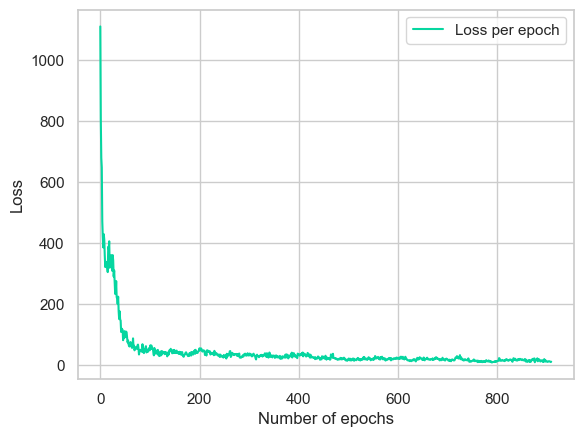

In [6]:
# Plot training loss curve
plt.plot(np.arange(len(iter_losses)), iter_losses, "-", color='#06D6A0', label="Loss per epoch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

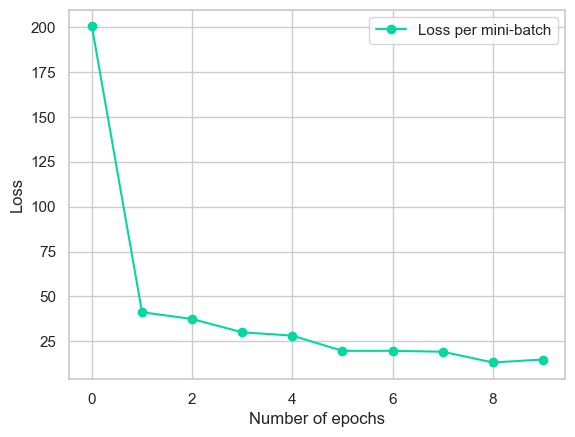

In [7]:
# Plot training loss curve
plt.plot(batch_losses, "o-", color='#06D6A0', label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()